In [5]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np

In [6]:
database = 'challenge.db'
connection = sql.connect(database)

### 1. Are the costs in the 'api_adwords_costs' table fully covered in the 'session_sources' table? Any campaigns where you see issues?

In [7]:
query ='''
with q1 as(
select 
campaign_id,
event_date,
sum(cost) as campaign_cost,
sum(clicks) as number_clicks
from api_adwords_costs
group by 1,2
)
,
q2 as(
SELECT
campaign_id,
event_date,
sum(cpc) as sum_cpc,
avg(cpc) as avg_cpc,
count(event_date) as event_count,
count(session_id) as session_count
FROM session_sources
group by 1,2
)
SELECT
case when sd.campaign_id is null then False else True end as event_in_sessions,
ad.campaign_id,
ad.event_date as date_,
ad.campaign_cost,
ad.number_clicks,
round(ad.campaign_cost/ad.number_clicks,3) as cpc_recalculated,
round(sd.sum_cpc,3) as sum_cpc,
round(sd.avg_cpc,3) as avg_cpc,
sd.event_count,
sd.session_count,
round(ad.campaign_cost - sum_cpc,3) as cost_diff_covered,
abs(round(ad.campaign_cost - sum_cpc,3)) as abs_cdc
from q1 as ad
left join q2 as sd
on (ad.campaign_id = sd.campaign_id) and (ad.event_date=sd.event_date)
order by abs_cdc asc
'''

In [8]:
df_1 = pd.read_sql_query(query,connection)
df_1

DatabaseError: Execution failed on sql '
with q1 as(
select 
campaign_id,
event_date,
sum(cost) as campaign_cost,
sum(clicks) as number_clicks
from api_adwords_costs
group by 1,2
)
,
q2 as(
SELECT
campaign_id,
event_date,
sum(cpc) as sum_cpc,
avg(cpc) as avg_cpc,
count(event_date) as event_count,
count(session_id) as session_count
FROM session_sources
group by 1,2
)
SELECT
case when sd.campaign_id is null then False else True end as event_in_sessions,
ad.campaign_id,
ad.event_date as date_,
ad.campaign_cost,
ad.number_clicks,
round(ad.campaign_cost/ad.number_clicks,3) as cpc_recalculated,
round(sd.sum_cpc,3) as sum_cpc,
round(sd.avg_cpc,3) as avg_cpc,
sd.event_count,
sd.session_count,
round(ad.campaign_cost - sum_cpc,3) as cost_diff_covered,
abs(round(ad.campaign_cost - sum_cpc,3)) as abs_cdc
from q1 as ad
left join q2 as sd
on (ad.campaign_id = sd.campaign_id) and (ad.event_date=sd.event_date)
order by abs_cdc asc
': no such table: api_adwords_costs

: 

In [ ]:
val_1 = len(df_1[df_1['event_in_sessions'] == 0])
val_2 = len(df_1[df_1['event_in_sessions'] == 1])

print(">>> {val} events were not covered with session source table".format(val=val_1))
print(">>> {val} events were covered with session source table".format(val=val_2))

>>> 79 events were not covered with session source table
>>> 2908 events were covered with session source table


In [ ]:
df_1_covered = df_1[df_1['event_in_sessions'] == 1].copy()

def interval_diff (x,y):
    if x/y < 0.01:
        val = '< 5 %'
    elif x/y > 0.01 and x/y < 0.05:
        val = '5 - 20 %'
    elif x/y > 0.05 and x/y < 0.20:
        val = '20 - 50%'
    elif x/y > 0.20 and x/y < 0.5:
        val = '20 - 50 %'
    elif x/y > 0.5:
        val = '50 < %'
    else:
        val = '0'
    return val 

df_1_covered ['interval_diff'] = df_1_covered .apply(lambda x: interval_diff(x.abs_cdc,x.campaign_cost),axis=1)
df_1_covered_grp = df_1_covered.groupby('interval_diff',as_index=False)['campaign_id'].count().rename(columns={'campaign_id':'number occasions'})
df_1_covered_grp 

,interval_diff,number occasions
0,20 - 50 %,30
1,20 - 50%,90
2,5 - 20 %,101
3,50 < %,47
4,< 5 %,2640


<li>The table groups the number of campaings by a interval difference between the cost found in api_adwords_costs and sessions</li>
<li>example: in 90 occasions the campaings+date, did not match the cost in the session table by differece greater than 5% and less than 20%</li>

In [ ]:
df_1_grph_1 = df_1_covered[['date_','campaign_cost','sum_cpc']].copy()
df_1_grph_1['day'] = [x[-2:] for x in df_1_grph_1['date_']].copy()
df_1_grph_1.rename(columns={'campaign_cost':'api_adwords_costs','sum_cpc':'session_sources'},inplace=True)
df_1_grph_1.drop(columns='date_',inplace=True)
df_1_grph_1 = df_1_grph_1.groupby('day',as_index=False).agg({'api_adwords_costs':'sum','session_sources':'sum'})
df_1_grph_1['diff_%'] = [(1-(x/y))*100 for x,y in zip(df_1_grph_1['session_sources'],df_1_grph_1['api_adwords_costs'])]
df_1_grph_1.sort_values(by='diff_%',ascending=False)

,day,api_adwords_costs,session_sources,diff_%
28,29,10675.390,10305.141,3.468248
27,28,11967.149,11565.369,3.357358
24,25,13113.050,12673.948,3.348588
30,31,10213.018,9874.295,3.316581
25,26,13131.584,12705.376,3.245671
29,30,10369.173,10039.450,3.179839
11,12,16380.534,15860.106,3.177113
9,10,13845.488,13410.966,3.138365
7,08,15804.864,15314.165,3.104734
0,01,20213.308,19588.740,3.089885


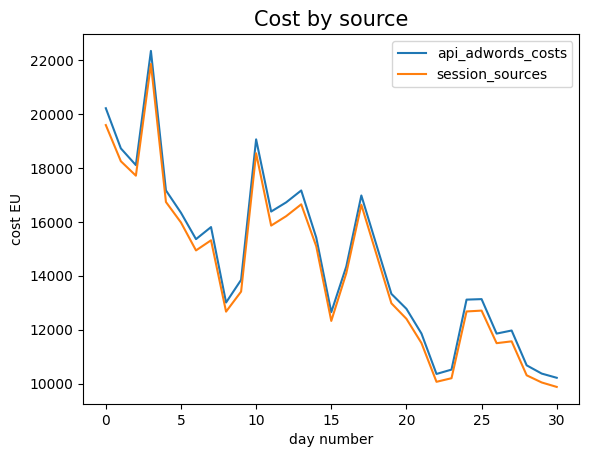

In [ ]:
df_1_grph_1.plot()
plt.title("Cost by table source", fontsize = 15)
plt.xlabel('day number')
plt.ylabel('cost EU')
plt.show()
print('the graph shows that there are periods when the discrepancies between both sources are higher, for example the last days of the month shows that during those days the difference was higher')

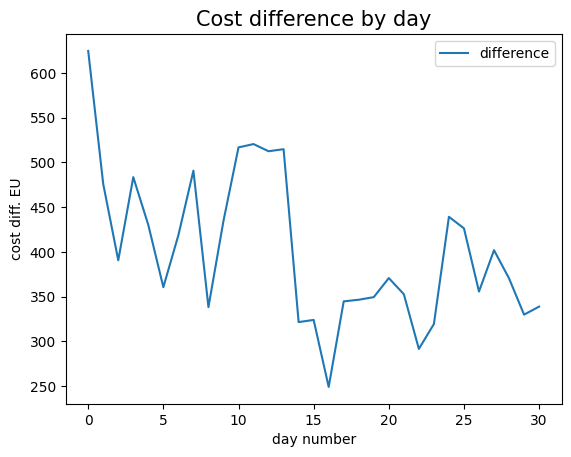

cost difference between both sources is decreasing month, but still not a stable Behaviour


In [ ]:
df_1_grph_1['difference'] = [x-y  for x,y in zip(df_1_grph_1['api_adwords_costs'],df_1_grph_1['session_sources']) ]
df_1_grph_2 = df_1_grph_1[['day','difference']]

df_1_grph_2.plot()
plt.title("Cost difference by day", fontsize = 15)
plt.xlabel('day number')
plt.ylabel('cost diff. EU')
plt.show()
print('cost difference between both sources is decreasing month, but still not a stable Behaviour')

In [ ]:
print('Table shows the top 10 campaigns which have the highest difference between api_adwors and sessions table')
df_1_covered_camp = df_1_covered.groupby('campaign_id',as_index=False)[['campaign_cost','sum_cpc','cost_diff_covered']].sum().sort_values(by='cost_diff_covered', ascending= False).head(10)
print('>> campaign_id_79 have no events in the sessions table, this can be potential bug that needs to be fixed.')
df_1_covered_camp

Table shows the top 10 campaigns which have the highest difference between api_adwors and sessions table
>> campaign_id_79 have no events in the sessions table, this can be potential bug that needs to be fixed.


,campaign_id,campaign_cost,sum_cpc,cost_diff_covered
93,campaign_id_79,11756.158,0.000,11756.158
88,campaign_id_73,5226.558,5072.821,153.737
68,campaign_id_52,12532.689,12452.136,80.553
56,campaign_id_35,7219.965,7144.232,75.733
103,campaign_id_94,96.700,40.740,55.960
65,campaign_id_5,754.646,711.712,42.934
36,campaign_id_156,118.883,90.823,28.060
53,campaign_id_3,1034.960,1011.778,23.182
46,campaign_id_22,488.526,466.806,21.720
29,campaign_id_147,225.460,204.784,20.676


### 2. Are the conversions in the 'conversions' table stable over time? Any pattern?

In [ ]:
query = '''
SELECT
cast (strftime('%d', conv_date) as integer) as day,
market,
count(conv_date) as number_conv,
count(distinct user_id)as number_user,
round(sum(revenue),2) as revenue
  from conversions
  group by 1,2
  order by market,revenue desc
'''

In [ ]:
df_2 = pd.read_sql_query(query,connection)
df_2.head()


,day,market,number_conv,number_user,revenue
0,18,AT,90,89,5848.55
1,15,AT,57,57,3393.93
2,30,AT,50,50,2887.39
3,17,AT,33,33,2030.84
4,19,AT,30,30,1534.49


>>> number of coonversions increase


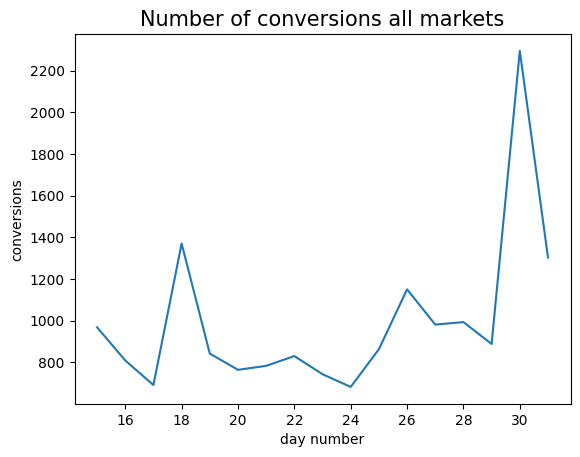

In [ ]:
df_2_grp_1 = df_2[['day','number_conv']].groupby('day',as_index=False)['number_conv'].sum()
print('>>> The graph shows an increase of the number of conversions along the period of time. The sample is too small to define a pattern')

plt.plot(df_2_grp_1["day"], df_2_grp_1["number_conv"])
plt.title("Number of conversions all markets", fontsize = 15)
plt.xlabel('day number')
plt.ylabel('conversions')
plt.show()


In [ ]:
#Top 5 markets by revenue
df_2_rnk_5 = df_2[['market','revenue']].groupby('market',as_index=False)['revenue'].sum().sort_values(by='revenue',ascending=False).head(5)
print('>>> the table shows the top 5 market with the higher revenue:')
df_2_rnk_5

>>> the table shows the top 5 market with the higher revenue:


,market,revenue
22,NL,228729.43
12,GB,208428.39
5,DE,202972.13
11,FR,67396.02
6,DK,61241.00


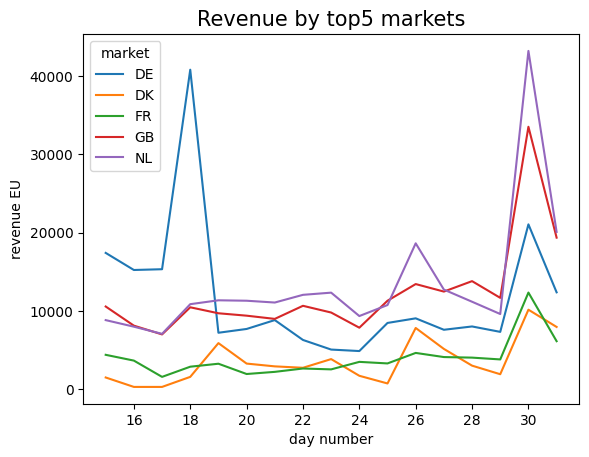

>>> In all markets there is a peak on the 30ths, the days before, all markets are stable with the exception of Germany that shows a peak on the 18th. This seems to be an anomality.


In [ ]:
top_5_list = df_2_rnk_5['market'].tolist()
df_2_top5 = df_2[df_2['market'].isin(top_5_list)]
df_2_top5 = pd.pivot_table(df_2_top5,columns='market',index='day',values='revenue').reset_index()
df_2_top5 = df_2_top5.set_index('day')

df_2_top5.plot()
plt.title("Revenue by top5 markets", fontsize = 15)
plt.xlabel('day number')
plt.ylabel('revenue EU')
plt.show()
print('>>> In all markets there is a peak on the 30ths, the days before, all markets are stable with the exception of Germany that shows a peak on the 18th. This seems to be an anomality.')

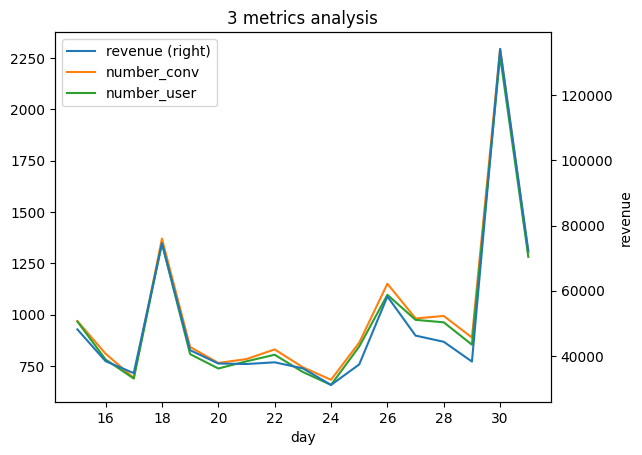

>>> The graph displays 3 metrics to analyse the table from 3 different perspectives. 
The most relevant outcome is what happened between the 26th and the 29th, 
in this period of time there is a drop of the revenue compared to the other 2 metrics. 
For example if the oragen line is above the green line, it means that the user did more than one conversion on average.
In this period the revenue line drops down, which means although users did more than one conversion on average, 
the conversion value was not as high as before


,day,revenue,number_conv,number_user
0,15,48140.04,968,966
1,16,38388.89,809,781
2,17,34721.01,691,688
3,18,74555.65,1370,1347
4,19,41764.69,842,807
5,20,37678.05,764,737
6,21,37516.15,783,772
7,22,38041.52,830,804
8,23,36188.87,743,720
9,24,31101.09,682,657


In [ ]:
df_2_3_metrics = df_2[['day','revenue','number_conv','number_user']].groupby('day',as_index=False).sum()
#df_2_3_metrics = df_2_3_metrics.set_index('day')
df_2_3_metrics

df_2_3_metrics.plot(x ='day',y=['revenue','number_conv','number_user'],kind='line',secondary_y='revenue')
plt.title('3 metrics analysis')
plt.ylabel('revenue')
plt.show()

print('>>> The graph displays 3 metrics to analyse the table from 3 different perspectives. \nThe most relevant outcome is what happened between the 26th and the 29th, \nin this period of time there is a drop of the revenue compared to the other 2 metrics. \nFor example if the oragen line is above the green line, it means that the user did more than one conversion on average.\nIn this period the revenue line drops down, which means although users did more than one conversion on average, \nthe conversion value was not as high as before')
df_2_3_metrics


### 3. Double check conversions ('conversions' table) with backend ('conversions_backend' table), any issues?

In [ ]:
query = '''
with q1 as (
SELECT
conv_id,
count(conv_id) as conv_count
from conversions
group by 1
having conv_count > 1
order by conv_count desc
)
SELECT
*
from conversions where conv_id in (select conv_id from q1)
order by conv_id
'''

In [ ]:
df_3_1 = pd.read_sql_query(query,connection)
val = len(df_3_1['conv_id'].unique())
print('>>> There are {val} conv_ids that have duplicated rows in conversion table: '.format(val = val))
df_3_1['conv_id'].unique()

>>> There are 16 conv_ids that have duplicated rows in conversion table: 


array(['conv_id_10826', 'conv_id_1128', 'conv_id_11991', 'conv_id_12394',
       'conv_id_12408', 'conv_id_13135', 'conv_id_15447', 'conv_id_159',
       'conv_id_16016', 'conv_id_16249', 'conv_id_16550', 'conv_id_1675',
       'conv_id_291', 'conv_id_5495', 'conv_id_6545', 'conv_id_843'],
      dtype=object)

In [ ]:
print('>>> the duplicated conv_ids have the same values across all columns, I will assume that this was a mistake of the data processing :')
df_3_1.head(6)

>>> the duplicated conv_ids have the same values across all columns, I will assume that this was a mistake of the data processing :


,conv_id,user_id,conv_date,market,revenue
0,conv_id_10826,user_id_172209,2021-07-30,NL,44.96
1,conv_id_10826,user_id_197806,2021-07-30,NL,44.96
2,conv_id_1128,user_id_1075383,2021-07-30,FR,68.33
3,conv_id_1128,user_id_592828,2021-07-30,FR,68.33
4,conv_id_11991,user_id_1111998,2021-07-28,GB,70.72
5,conv_id_11991,user_id_8521,2021-07-28,GB,70.72


##### I will drop this duplications with a DISTINCT operation, as conv_id should be a unique entry per row:

In [ ]:
query = '''
--diff between tables
with q1 as (
select
DISTINCT
user_id,
conv_id,
revenue
from conversions
)
,
q2 as (
select 
'conversions' as table_,
count(user_id) as count_distinct_user,
count(conv_id) as count_conv_id,
round(sum(revenue),2) as revenue
from q1
)
,
q3 as (
select
DISTINCT
user_id,
conv_id,
revenue
from conversions_backend 
)
,
q4 as (
select
'conversions_backend' as table_,
count(user_id) as count_distinct_user,
count(conv_id) as count_conv_id,
round(sum(revenue),2) as revenue
from q3
)
select
*
from q2
union 
select
*
from q4
'''

In [ ]:
df_3_2 = pd.read_sql_query(query,connection)
val = df_3_2.iloc[1:2,1:2].values[0][0] -df_3_2.iloc[0:1,1:2].values[0][0]
print(">>> The conversion_backend table convers more events than the conersion table. Example {val} more conv_ids than in conversions.\nThis could happend because in a backend table you can also find fraud data that needs to be filter out before it arrives to data consumer's table.".format(val=val))
df_3_2


>>> The conversion_backend table convers more events than the conersion table. Example 329 more conv_ids than in conversions.
This could happend because in a backend table you can also find fraud data that needs to be filter out before it arrives to data consumer's table.


,table_,count_distinct_user,count_conv_id,revenue
0,conversions,16954,16954,849102.67
1,conversions_backend,17283,17283,877250.86


#### Check through time if discrepancies are concentrated in specific periods 

In [ ]:
query = '''
with q1 as (
select
DISTINCT
user_id,
campaign_name
from session_sources
)
,
q2 as (
select 
DISTINCT
market,
conv_date,
conv_id,
user_id,
revenue
from conversions)
,
q3 as (
SELECT
DISTINCT
market,
conv_date,
conv_id,
user_id,
revenue
from conversions_backend
)
select 
c.conv_date,
c.conv_id,
c.user_id,
c.market,
ss.campaign_name,
count(c.conv_id) as c_conv_id,
count(cb.conv_id) as cb_conv_id,
sum(c.conv_id) - sum(cb.conv_id) as diff_conv_id,
sum(c.revenue) as c_revenue,
sum(cb.revenue) as cb_revenue,
sum(c.revenue) - sum(cb.revenue) as diff_revenues

from q2 as c
left join q3 as cb on (c.conv_id=cb.conv_id) and (c.conv_date = cb.conv_date) and (c.user_id=cb.user_id)  and (c.market=cb.market)
left join q1 as ss on (c.user_id= ss.user_id)
group by 1,2,3,4,5
order by diff_revenues asc
'''

In [ ]:
df_3_3 = pd.read_sql_query(query,connection)
df_3_3

,conv_date,conv_id,user_id,market,campaign_name,c_conv_id,cb_conv_id,diff_conv_id,c_revenue,cb_revenue,diff_revenues
0,2021-07-15,conv_id_16016,user_id_28526,NL,None,1,0,NaN,30.99,NaN,NaN
1,2021-07-15,conv_id_16249,user_id_182167,AT,None,1,0,NaN,161.35,NaN,NaN
2,2021-07-16,conv_id_159,user_id_26171,DE,None,1,0,NaN,100.83,NaN,NaN
3,2021-07-18,conv_id_15447,user_id_998630,BE,None,1,0,NaN,36.53,NaN,NaN
4,2021-07-18,conv_id_16550,user_id_868787,GB,None,1,0,NaN,197.27,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23486,2021-07-31,conv_id_9925,user_id_544826,DE,campaign_name_271,1,1,0.0,14.24,14.24,0.0
23487,2021-07-31,conv_id_9927,user_id_293812,GB,campaign_name_271,1,1,0.0,58.66,58.66,0.0
23488,2021-07-31,conv_id_9927,user_id_293812,GB,campaign_name_741,1,1,0.0,58.66,58.66,0.0
23489,2021-07-31,conv_id_9946,user_id_639197,GB,campaign_name_271,1,1,0.0,62.68,62.68,0.0


In [ ]:
# replacing NAN for cero
df_3_3.fillna(0,inplace=True)

### Revenue

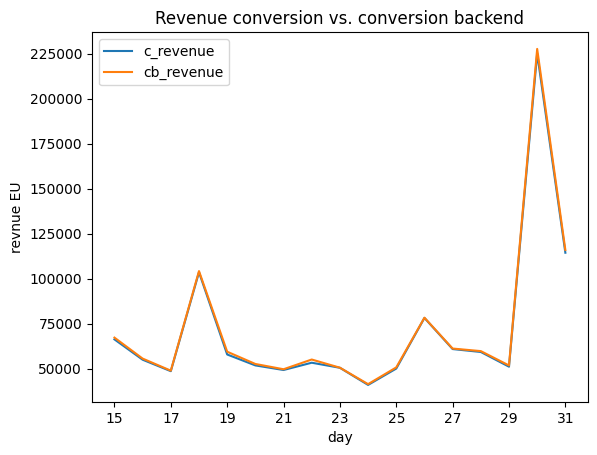

>>> revenue: from the graph and the table there are 2 days when the discrepancies are consider highger than the rest of the other days --> day 19 and 22, but not significant for a conclusion


,day,c_revenue,cb_revenue,diff_%
0,15,66263.07,67238.10,1.5
1,16,54968.15,55590.45,1.1
2,17,48600.97,48885.55,0.6
3,18,103574.54,104206.13,0.6
4,19,57870.74,59417.90,2.6
5,20,51799.15,52596.08,1.5
6,21,49250.27,49665.36,0.8
7,22,53293.72,55072.52,3.2
8,23,50482.14,50531.79,0.1
9,24,40959.22,41399.43,1.1


In [ ]:
df_3_3['day'] = [x[-2:] for x in df_3_3['conv_date']]
df_3_2_grp = df_3_3[['day','c_revenue','cb_revenue']].groupby('day',as_index=False).sum()
df_3_2_grp.plot(x = 'day',y =['c_revenue','cb_revenue'],kind='line')
plt.ylabel('revnue EU')
plt.title('Revenue conversion vs. conversion backend')
plt.show()
print('>>> revenue: from the graph and the table there are 2 days when the discrepancies are consider highger than the rest of the other days --> day 19 and 22, but not significant for a conclusion')
df_3_2_grp['diff_%'] = [(1- round(x/y,3))*100 for x,y in zip(df_3_2_grp['c_revenue'],df_3_2_grp['cb_revenue'])]
df_3_2_grp


In [ ]:
## by market
df_3_2_mrkt = df_3_3[['market','c_revenue','cb_revenue']].groupby('market',as_index= False).sum()
df_3_2_mrkt['diff_%'] = [(1-round(x/y,3))*100 for x,y in zip(df_3_2_mrkt['c_revenue'],df_3_2_mrkt['cb_revenue'])]
print('revenue: by market DK represents the market with the higher reveneu differrence between both tables --> 2.1%')
df_3_2_mrkt

revenue: by market DK represents the market with the higher reveneu differrence between both tables --> 2.1%


,market,c_revenue,cb_revenue,diff_%
0,AT,41243.73,41150.14,-0.2
1,BE,45558.03,45943.52,0.8
2,BG,471.50,471.50,0.0
3,CY,155.54,155.54,0.0
4,CZ,1285.73,1285.73,0.0
5,DE,293541.75,298787.95,1.8
6,DK,81448.32,83157.56,2.1
7,EE,1297.12,1297.12,0.0
8,ES,2874.25,2874.25,0.0
9,EU,34.95,34.95,0.0


In [ ]:
def diff_calc(x,y):
    try:
        val = abs((1-round(x/y,3))*100)
    except:
        val = 0
    return val

# by campaign name
df_3_2_camp = df_3_3[['campaign_name','c_revenue','cb_revenue']].groupby('campaign_name',as_index= False).sum()
df_3_2_camp['diff_%'] = df_3_2_camp.apply(lambda x: diff_calc(x.c_revenue,x.cb_revenue), axis=1)
df_3_2_camp['diff'] = [int(y-x) for x,y in zip(df_3_2_camp['c_revenue'],df_3_2_camp['cb_revenue'])]

print('>>> top 30 campaigns with the highest % revenue difference between tables:')
df_3_2_camp.sort_values(by='diff_%',ascending=False).head(30)


>>> top 30 campaigns with the highest % revenue difference between tables:


,campaign_name,c_revenue,cb_revenue,diff_%,diff
164,campaign_name_402,0.00,7.02,100.0,7
27,campaign_name_1073,791.95,1019.43,22.3,227
158,campaign_name_389,311.46,363.53,14.3,52
240,campaign_name_592,168.77,193.05,12.6,24
289,campaign_name_716,1972.21,2231.95,11.6,259
163,campaign_name_401,1666.24,1882.78,11.5,216
70,campaign_name_150,2491.73,2762.23,9.8,270
29,campaign_name_1075,950.57,1033.06,8.0,82
39,campaign_name_1116,371.05,397.68,6.7,26
254,campaign_name_635,1428.26,1527.60,6.5,99


#### 4. Are attribution results consistent? Do you find any conversions where the 'ihc' values don't make sense?

In [ ]:
query = '''
SELECT 
c.conv_id,
CAST(sum(acc.ihc) as float) as ihc_sum,
round(CAST(sum(acc.ihc) as float)-1,3) as diff
from conversions as c
left join attribution_customer_journey as acc
on c.conv_id = acc.conv_id
group by 1
--having diff <>0
order by diff DESC
'''

In [ ]:
def ctg_diff (x):
    if x == 0:
        val= 'equal'
    elif x >0:
        val= 'greater'
    elif x <0:
        val = 'lower'
    else:
        val = 'no left join'
    return val
#ctg_diff(4)

In [ ]:
df_4_1 = pd.read_sql_query(query,connection)
df_4_1['ctg_diff'] = df_4_1.apply(lambda x: ctg_diff(x['diff']),axis=1)
print(">>> considering that ihc needs to be exactly equals to 1, there were 6702 conversions that were equal to 1, 200 conversions not equal to 1 and 10076 conversions were not found in the ACJ table.")
df_4_1.groupby('ctg_diff',as_index=False)['conv_id'].count()

>>> considering that ihc needs to be exactly equals to 1, there were 6702 conversions that were equal to 1, 200 conversions not equal to 1 and 10076 conversions were not found in the ACJ table.


,ctg_diff,conv_id
0,equal,6702
1,greater,5
2,lower,155
3,no left join,10076


##### 5. (Bonus) Do we have an issue with channeling? Are the number of sessions per channel stable over time?

In [ ]:
query = '''
with q1 as (
SELECT
cast (strftime('%d', event_date) as integer) as day_,
cast(count(session_id) as float) as count_sessions,
round(cast(avg(cpc) as float),3) as avg_cpc
from session_sources
group by 1
)
SELECT
*,
round(cast(count_sessions as float)/sum(count_sessions) over (),3) as session_percent
from q1
'''

In [ ]:
df_5_1 = pd.read_sql_query(query,connection)
df_5_1

,day_,count_sessions,avg_cpc,session_percent
0,1,62325.0,0.513,0.039
1,2,57045.0,0.553,0.035
2,3,53895.0,0.532,0.033
3,4,73342.0,0.463,0.045
4,5,61594.0,0.477,0.038
5,6,56124.0,0.478,0.035
6,7,60318.0,0.398,0.037
7,8,50212.0,0.444,0.031
8,9,46214.0,0.427,0.029
9,10,52236.0,0.442,0.032


>>> Sessions decreasing over time:


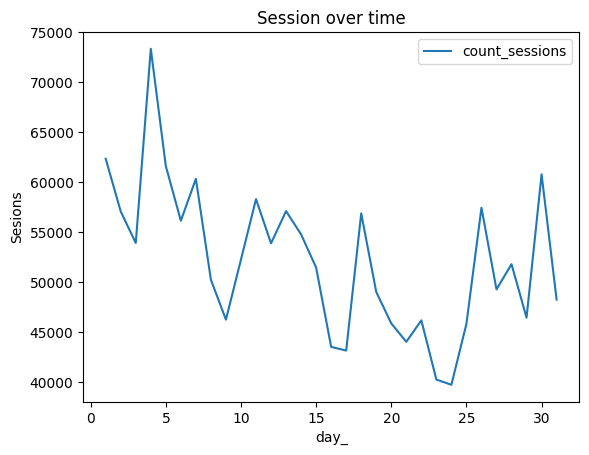

In [ ]:
df_5_1.plot(x='day_',y=['count_sessions'],kind='line')
plt.ylabel('Sesions')
plt.title('Session over time')
print('>>> Sessions decreasing over time:')

In [ ]:
query = '''
with q1 as (
SELECT
market,
channel_name,
cast (strftime('%d', event_date) as integer) as day_,
case cast (strftime('%w', event_date) as integer)
when 0 then 'Sunday'
when 1 then 'Monday'
when 2 then 'Tuesday'
when 3 then 'Wednesday'
when 4 then 'Thursday'
when 5 then 'Friday'
else 'Saturday' end as weekday,
cast(count(session_id) as float) as count_sessions
from session_sources
group by 1,2,3,4
)
SELECT
*,
round(cast(count_sessions as float)/sum(count_sessions) over (),3) as session_percent_all,
round(cast(count_sessions as float)/sum(count_sessions) over (),3) as session_percent_channel_name
from q1

'''

In [ ]:
df_5_2 = pd.read_sql_query(query,connection)
df_5_2.head()

,market,channel_name,day_,weekday,count_sessions,session_percent_all,session_percent_channel_name
0,DE,Affiliate,1,Thursday,420.0,0.0,0.0
1,DE,Affiliate,2,Friday,247.0,0.0,0.0
2,DE,Affiliate,3,Saturday,240.0,0.0,0.0
3,DE,Affiliate,4,Sunday,257.0,0.0,0.0
4,DE,Affiliate,5,Monday,238.0,0.0,0.0


In [ ]:
df_5_2_grp = df_5_2.groupby('channel_name',as_index=False)['count_sessions'].sum()
channel_name_lst = df_5_2_grp.sort_values(by='count_sessions', ascending=False).head(5)['channel_name'].tolist()
print("Top 5 channels:")
channel_name_lst

Top 5 channels:


['SEO', 'Direct', 'Shopping - Non-branded', 'Social - Paid', 'Email']

>>> Direct, Shopping - Non-branded and Social channels are recovering after a drop durng the first days of the month. SEO have stable behaviour and Email looks to fluctuates at lot.


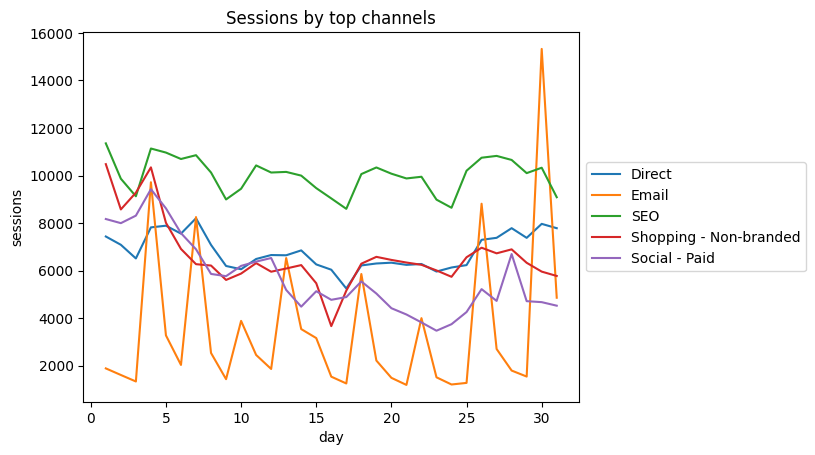

In [ ]:
df_5_2_ch = df_5_2[['channel_name','day_','count_sessions']]
df_5_2_ch = df_5_2_ch[df_5_2_ch['channel_name'].isin(channel_name_lst)]
df_5_2_ch_pvt = pd.pivot_table(df_5_2_ch,columns='channel_name',values='count_sessions',index='day_',aggfunc='sum').reset_index()
df_5_2_ch_pvt = df_5_2_ch_pvt.set_index('day_')
df_5_2_ch_pvt = df_5_2_ch_pvt.fillna(0)


df_5_2_ch_pvt.plot()
plt.title('Sessions by top channels')
plt.xlabel('day')
plt.ylabel('sessions')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
print('>>> Direct, Shopping - Non-branded and Social channels are recovering after a drop durng the first days of the month. SEO have stable behaviour and Email looks to fluctuates at lot.')

>>> Most of the channels get more sessions on Thursdays, Email has a different behaviour.


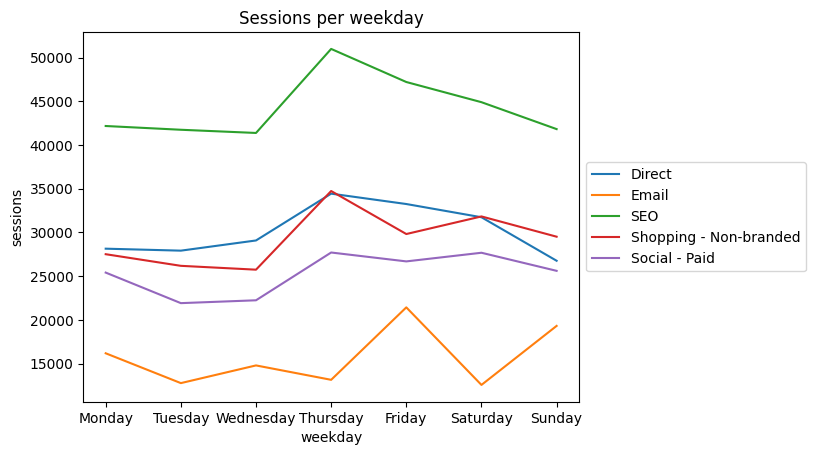

In [ ]:
df_5_2_ch_wd = df_5_2[['channel_name','weekday','count_sessions']]
df_5_2_ch_wd = df_5_2_ch_wd[df_5_2_ch_wd['channel_name'].isin(channel_name_lst)]
df_5_2_ch_wd_grp = df_5_2_ch_wd.groupby(['channel_name','weekday'],as_index=False)['count_sessions'].sum()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_5_2_ch_wd_pvt = pd.pivot_table(df_5_2_ch_wd_grp,columns='channel_name',index='weekday',values='count_sessions',aggfunc='sum').reset_index()
ax = df_5_2_ch_wd_pvt.set_index("weekday").loc[day_order].plot(kind="line", legend=False)
plt.title('Sessions per weekday')
plt.ylabel('sessions')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
print('>>> Most of the channels get more sessions on Thursdays, Email has a different behaviour.')

In [ ]:
df_5_2_ch_grp_ch_dy = df_5_2_ch.groupby(by=['channel_name','day_'],as_index=False).sum()
df_5_2_ch_grp_ch_dy.groupby(by='channel_name',as_index=False).agg(max=('count_sessions',max),min=('count_sessions',min),mean=('count_sessions',np.mean))

,channel_name,max,min,mean
0,Direct,8203.0,5250.0,6818.129032
1,Email,15325.0,1195.0,3554.225806
2,SEO,11353.0,8600.0,10008.935484
3,Shopping - Non-branded,10479.0,3668.0,6624.709677
4,Social - Paid,9425.0,3475.0,5718.193548


>>> On one hand the sessions in markets such DK, EU and FR are more stable, on the other hand GB and NL are just recovering from a drop of their sessions at the beginnig of the month.


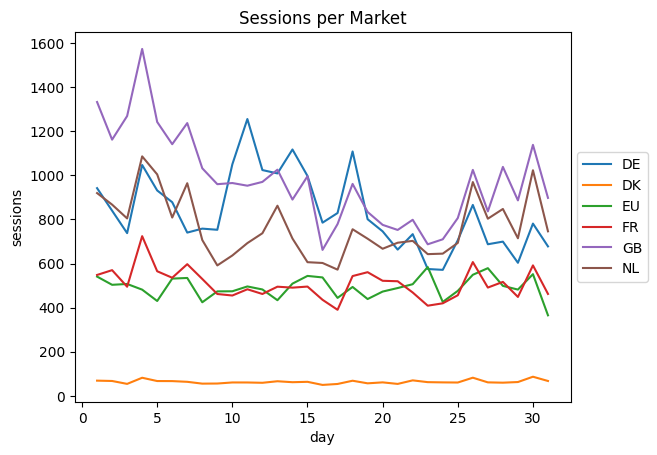

In [ ]:
df_5_2.groupby(['market','day_'], as_index=False)['count_sessions'].sum()
df_5_2_mrkt = pd.pivot_table(df_5_2,columns='market',index='day_',values='count_sessions').reset_index()
df_5_2_mrkt.plot(x='day_',title='Sessions per Market')
plt.xlabel('day')
plt.ylabel('sessions')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
print(">>> On one hand the sessions in markets such DK, EU and FR are more stable, on the other hand GB and NL are just recovering from a drop of their sessions at the beginnig of the month.")